In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

sys.path.append('../')
sys.path.append('../Lib')
sys.path.append('../Models')
sys.path.append('../Protocols')
from cell_models import kernik, protocols, paci_2018

import mod_protocols
import protocol_lib
import mod_kernik as kernik
import mod_trace as trace
from Models.br1977 import BR1977
from ord2011 import ORD2011
import model_response

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
is_optimized_protocol = False
trial_conditions = "ORD2011_Leem_v1"
if is_optimized_protocol:
    trial_conditions = "ORD2011_504_101_4_-121_61_10_5"
    
prestep = 5000
window = 10
step_size = 5
holding_step = 500
only_end = False
with_artefact = False
model_name = trial_conditions.split('_')[0]
path_to_data = f"ga_results/{trial_conditions}"
if not os.path.exists(path_to_data):
    os.makedirs(path_to_data)


In [3]:
final_protocol = None

if is_optimized_protocol:

    files = os.listdir(path_to_data)
    for f in files:
        if ('pkl' in f) and (f'p{prestep}' in f) and (f'h{holding_step}' in f) and (f'oe{only_end}' in f):
            file_name = f
    print(file_name)
    final_protocol = pickle.load(open(f"{path_to_data}/{file_name}", 'rb'))    
    
else :
    final_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=200) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=40) )  # <- why?? vo
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
    final_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=200)) # ramp step
    # final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
    # final_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=100) )
    # final_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=500) )
    # final_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=60, voltage_end=-80, duration=200)) # ramp step
    
print(f'The protocol is {final_protocol.get_voltage_change_endpoints()[-1]} ms')
# times = np.arange(0, final_protocol.get_voltage_change_endpoints()[-1], 1) 
# final_protocol.plot_voltage_clamp_protocol(times)

The protocol is 1320 ms


In [4]:
start_time = time.time()

currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_CaL', 'I_K1', 'I_NaL' ]               
tr = None
if model_name=='ORD2011' :
    model = ORD2011(final_protocol, is_exp_artefact=with_artefact)
    tr = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='OHara2017':
    model = '../mmt-model-files/ohara-cipa-v1-2017_VC.mmt'
    tr = model_response.get_model_response_with_myokit(model, final_protocol, prestep=prestep)
elif model_name=='BR1977' :
    currents = ['I_Na', 'I_si', 'I_K1', 'I_x1']
    model = BR1977(final_protocol)  
    tr = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='Kernik':
    currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_F', 'I_CaL', 'I_K1'] 
    k = kernik.KernikModel(is_exp_artefact=with_artefact)        
    tr = k.generate_response(final_protocol, is_no_ion_selective=False)

current_contributions = tr.current_response_info.get_current_contributions( time=tr.t, window=window, step_size=step_size)
max_contributions = tr.current_response_info.get_max_current_contributions(tr.t, window=window, step_size=step_size)
print("--- %s seconds ---"%(time.time()-start_time))

--- 4.586236476898193 seconds ---


In [5]:
current_contributions

,Time Start,Time End,Time Mid,I_Na,I_NaL,I_To,I_CaL,I_CaNa,I_CaK,I_Kr,...,I_NaK,I_Kb,I_Nab,I_Cab,I_pCa,I_F,I_up,I_leak,I_no_ion,I_stim
0,0,10,5.0,6.640933e-03,2.340527e-04,0.000229,2.373377e-06,1.328943e-07,5.016379e-10,0.000006,...,0.075630,0.000116,0.013678,0.015267,0.000051,0.0,0.0,0.0,0.0,0.0
1,5,15,10.0,6.641015e-03,2.340556e-04,0.000229,2.373402e-06,1.328958e-07,5.016385e-10,0.000006,...,0.075629,0.000116,0.013678,0.015267,0.000051,0.0,0.0,0.0,0.0,0.0
2,10,20,15.0,6.641075e-03,2.340576e-04,0.000229,2.373420e-06,1.328968e-07,5.016389e-10,0.000006,...,0.075628,0.000116,0.013678,0.015267,0.000051,0.0,0.0,0.0,0.0,0.0
3,15,25,20.0,6.641134e-03,2.340597e-04,0.000229,2.373438e-06,1.328978e-07,5.016393e-10,0.000006,...,0.075627,0.000116,0.013678,0.015267,0.000051,0.0,0.0,0.0,0.0,0.0
4,20,30,25.0,6.641194e-03,2.340618e-04,0.000229,2.373456e-06,1.328988e-07,5.016398e-10,0.000006,...,0.075626,0.000116,0.013678,0.015268,0.000051,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,1290,1300,1295.0,1.914485e-05,5.233307e-07,0.000019,8.379248e-09,4.588553e-10,1.579757e-12,0.041524,...,0.015871,0.000014,0.003908,0.004465,0.000022,0.0,0.0,0.0,0.0,0.0
259,1295,1305,1300.0,4.691841e-06,2.023713e-07,0.000013,2.196712e-09,1.198846e-10,5.430927e-13,0.034524,...,0.010366,0.000010,0.002722,0.003120,0.000015,0.0,0.0,0.0,0.0,0.0
260,1300,1310,1305.0,1.230699e-06,8.458338e-08,0.000010,6.425449e-10,3.496493e-11,1.906577e-13,0.028952,...,0.007481,0.000008,0.002091,0.002404,0.000011,0.0,0.0,0.0,0.0,0.0
261,1305,1315,1310.0,3.371316e-07,3.699079e-08,0.000007,2.018764e-10,1.095810e-11,6.837836e-14,0.024484,...,0.005767,0.000006,0.001715,0.001976,0.000008,0.0,0.0,0.0,0.0,0.0


In [6]:
max_contributions

,Current,Contribution,Time Start,Time End
0,I_Na,0.640416,300.0,310.0
1,I_NaL,0.332997,320.0,330.0
2,I_To,0.052094,625.0,635.0
3,I_CaL,0.831539,585.0,595.0
4,I_CaNa,0.108857,620.0,630.0
5,I_CaK,0.182173,620.0,630.0
6,I_Kr,0.679759,1205.0,1215.0
7,I_Ks,0.253069,1110.0,1120.0
8,I_K1,0.965468,1310.0,1320.0
9,I_NaCa,0.130630,1275.0,1285.0


In [7]:
def plot_1d(ax, x, ys, title=None, colors=None, ylabel=None, xlim=None, ylim=None):
    
    for i, (key, value) in enumerate(ys.items()):        
        c = None
        if colors:  
            c = colors[i]
        ax.plot( x, value, label=key, color=c, linewidth=2)               
        
    if title:
        ax.set_title(ylabel)
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])    
    if ylabel:
        ax.set_ylabel( ylabel, fontsize=14) 
    ax.set_xlabel('Time (ms)', fontsize=14)  
    ax.tick_params( axis="x", labelsize=14)
    ax.tick_params( axis="y", labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)     
    ax.legend(loc=2, prop={'size': 14})    
    # ax.grid()
    
    return ax

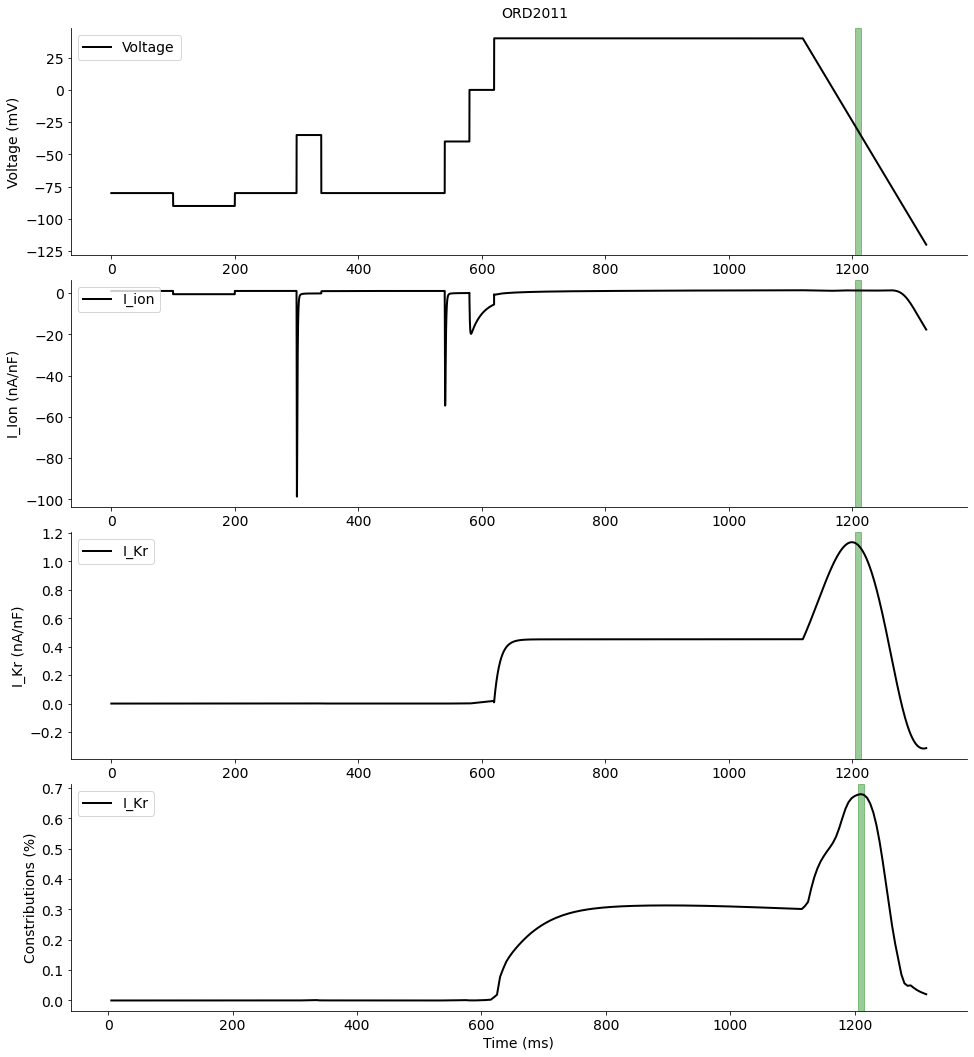

In [8]:
'''
Plot
'''
fig, axes = plt.subplots(4,1, figsize=(15,15))    
fig.suptitle(model_name, fontsize=14)

current_name = 'I_Kr'
xlim = None 
ylim = None

##
plot_1d(axes[0], x=tr.t, ys={'Voltage' : final_protocol.get_voltage_clamp_protocol(tr.t)}, ylabel='Voltage (mV)', colors=['k'], xlim=xlim, ylim=ylim)
plot_1d(axes[1], x=tr.t, ys={'I_ion' : tr.current_response_info.get_current_summed()}, ylabel='I_Ion (nA/nF)', colors=['k'], xlim=xlim, ylim=ylim)
plot_1d(axes[2], x=tr.t, ys={current_name : tr.current_response_info.get_current([current_name]) }, ylabel=f'{current_name} (nA/nF)', colors=['k'], xlim=xlim, ylim=ylim)
plot_1d(axes[-1], x=current_contributions['Time Mid'], ys={current_name : current_contributions[current_name] }, ylabel='Constributions (%)', colors=['k'], xlim=xlim, ylim=ylim)

#=========================================================================================================
contribution = max_contributions[max_contributions["Current"]==current_name]['Contribution'].values[0]
start = max_contributions[max_contributions["Current"]==current_name]['Time Start'].values[0]
end = max_contributions[max_contributions["Current"]==current_name]['Time End'].values[0]         
for i in range(4):
    axes[i].axvspan(start, end, color='g', alpha=0.4)  
#=========================================================================================================
    
#=========================================================================================================
if is_optimized_protocol:
    
    total_duration = holding_step
    for i, name in enumerate( currents):  
        ##
        short_protocol = pickle.load(open(f"{path_to_data}/short_{name}_p{prestep}_oe{only_end}_a{with_artefact}.pkl", 'rb'))                             
        for j in range(4):            
            axes[j].axvspan(total_duration, total_duration+short_protocol.get_voltage_change_endpoints()[-1], color='b' if name==current_name else 'k', alpha=.1)                        
        total_duration += short_protocol.get_voltage_change_endpoints()[-1]+holding_step
#=========================================================================================================
    
# ax_im = axes[2].scatter(tr.t, tr.current_response_info.get_current([current_name]), c=c_li[current_name], cmap=cm.copper, vmin=0, vmax=1)
# fig = plt.gcf()
# cbar_ax = fig.add_axes([0.92, 0.08, 0.05, 0.85])
# fig.colorbar(ax_im, cax=cbar_ax)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.9, top=0.96, wspace=0.5, hspace=0.11)
plt.show()
if is_optimized_protocol:
    fig.savefig( f"{path_to_data}/{trial_conditions}_h{holding_step}_p{prestep}_oe{only_end}_a{with_artefact}-1.jpg", dpi=200)    
else:
    fig.savefig( f"{path_to_data}/{trial_conditions}_p{prestep}_a{with_artefact}-1.jpg", dpi=200)
plt.close(fig)

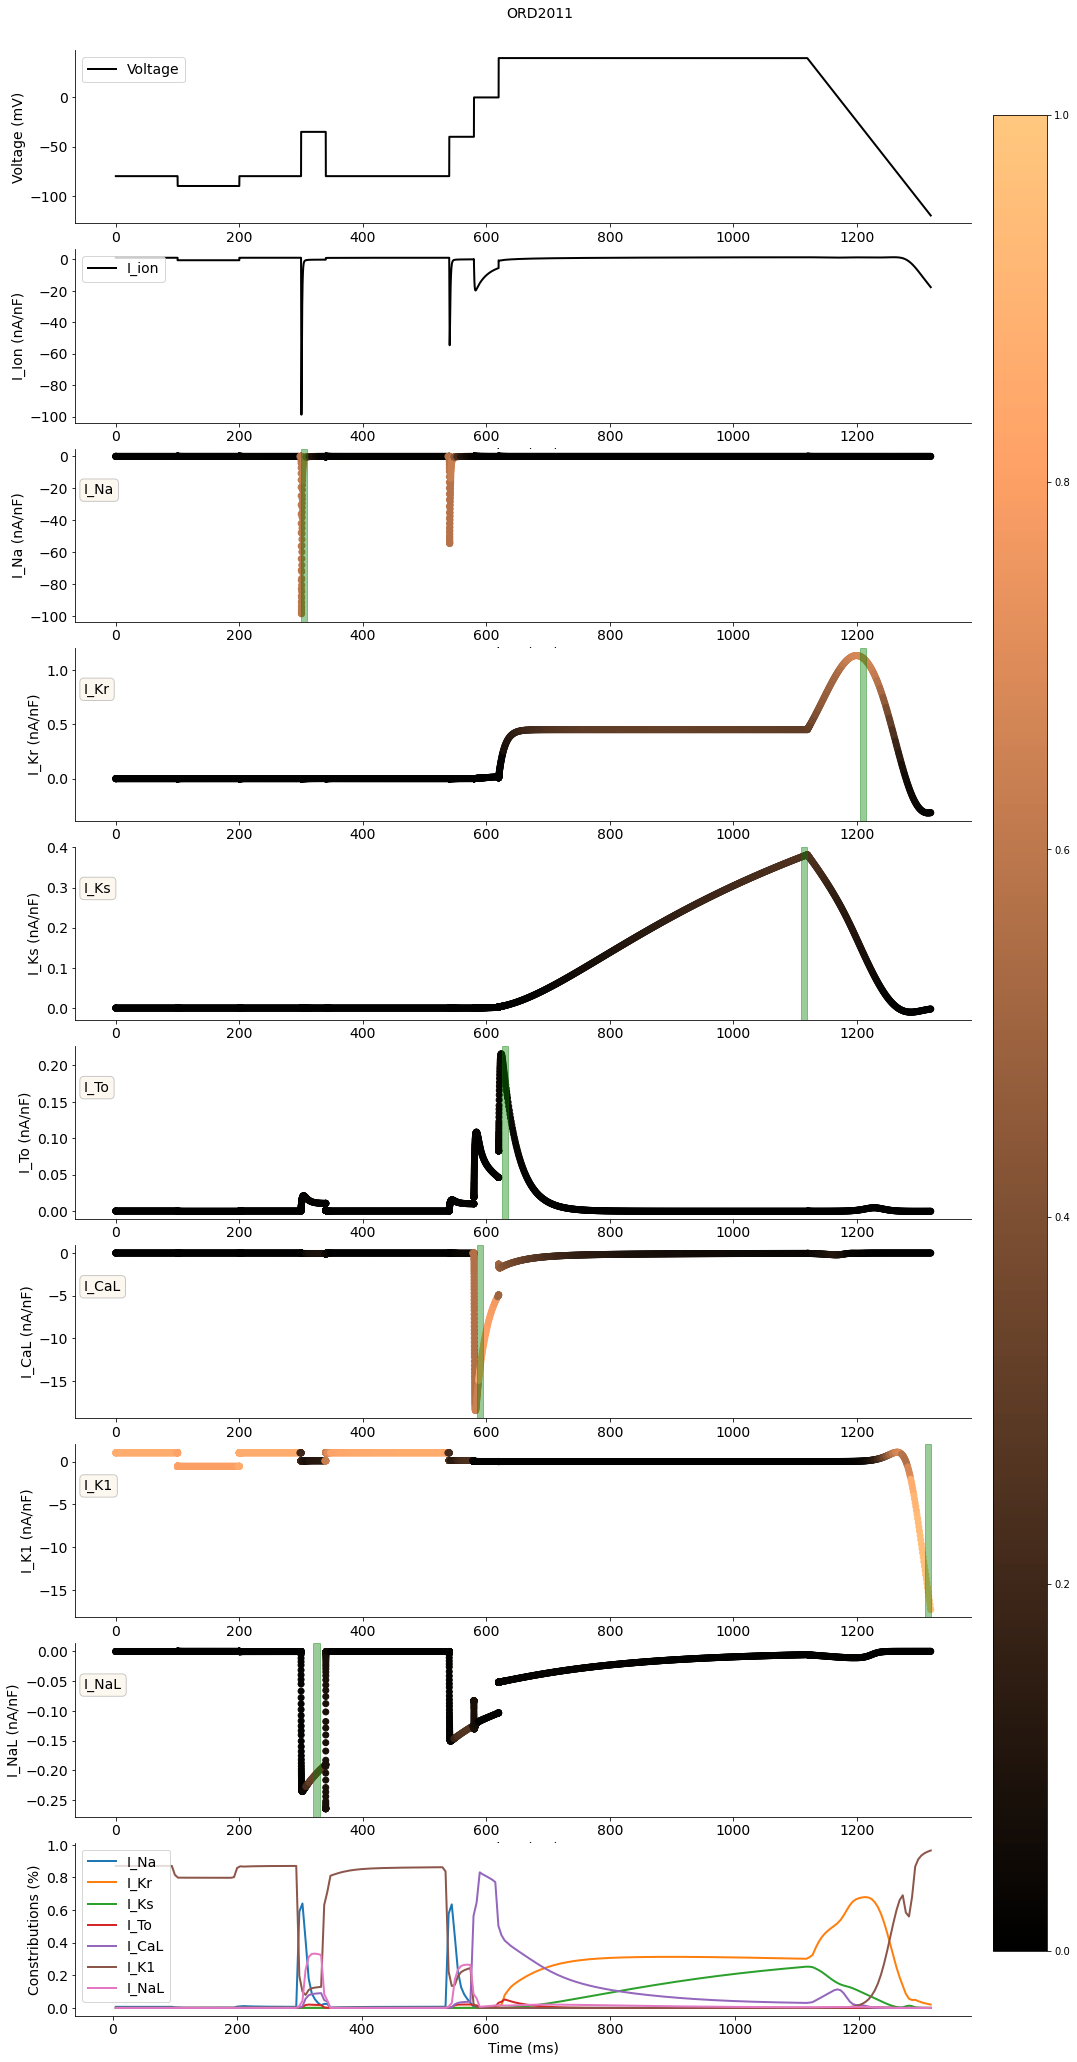

In [11]:
'''
Plot
'''
fig, axes = plt.subplots(len(currents)+3,1, figsize=(15,30))    
fig.suptitle(model_name, fontsize=14)

xlim = None # model_scipy.times.min(), model_scipy.times.max()
ylim = None

plot_1d(axes[0], x=tr.t, ys={'Voltage' : final_protocol.get_voltage_clamp_protocol(tr.t)}, ylabel='Voltage (mV)', colors=['k'], xlim=xlim, ylim=ylim)
plot_1d(axes[1], x=tr.t, ys={'I_ion' : tr.current_response_info.get_current_summed()}, ylabel='I_Ion (nA/nF)', colors=['k'], xlim=xlim, ylim=ylim)
plot_1d(axes[-1], x=current_contributions['Time Mid'], ys={current_name : current_contributions[current_name] for current_name in currents }, ylabel='Constributions (%)')
# plot_1d(axes[-1], x=tr.t, ys={current_name : c_li[current_name] }, ylabel='Constributions (%)', colors=['k'], xlim=xlim, ylim=ylim)

total_duration = holding_step
for i, name in enumerate( currents):        
    ax = axes[i+2]
    
    
    if is_optimized_protocol:
        short_protocol = pickle.load(open(f"{path_to_data}/short_{name}_p{prestep}_oe{only_end}_a{with_artefact}.pkl", 'rb'))  
        print(total_duration, total_duration+short_protocol.get_voltage_change_endpoints()[-1])
        for j in range(len(currents)+3):                      
            axes[j].axvspan(total_duration, total_duration+short_protocol.get_voltage_change_endpoints()[-1], color='b' if i+2==j else 'k', alpha=.1)                        
        total_duration += short_protocol.get_voltage_change_endpoints()[-1]+holding_step
      
    ##
    color_li = []
    for t in tr.t:   
        idx = current_contributions['Time Mid'].sub(t).abs().idxmin()
        color_li.append( current_contributions[name].loc[idx] )    
    ax_im = ax.scatter(tr.t, tr.current_response_info.get_current([name]), c=color_li, cmap=cm.copper, vmin=0, vmax=1, label=[name, name])                
    
    ##
    contribution = max_contributions[max_contributions["Current"]==name]['Contribution'].values[0]
    start = max_contributions[max_contributions["Current"]==name]['Time Start'].values[0]
    end = max_contributions[max_contributions["Current"]==name]['Time End'].values[0]         
    ax.axvspan(start, end, color='g', alpha=0.4)   
    
    #     ax[i].set_title(name)
    ax.set_xlabel('Time (ms)', fontsize=14)           
    ax.set_ylabel(f'{name} (nA/nF)', fontsize=14) 
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)             
    ax.text(0.01, 0.8, name, transform=ax.transAxes, fontsize=14, verticalalignment='top', c='k',  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))            
    if xlim :
        ax_temp.set_xlim(model_scipy.times.min(), model_scipy.times.max())
    if ylim :
        ax_temp.set_ylim(ylim[0], ylim[1])
    
fig = plt.gcf()
cbar_ax = fig.add_axes([0.92, 0.08, 0.05, 0.85])
fig.colorbar(ax_im, cax=cbar_ax)
plt.subplots_adjust(left=0.07, bottom=0.05, right=0.9, top=0.96, wspace=0.5, hspace=0.15)
plt.show()
if is_optimized_protocol:
    fig.savefig( f"{path_to_data}/{trial_conditions}_h{holding_step}_p{prestep}_oe{only_end}_a{with_artefact}-2.jpg", dpi=200)    
else:
    fig.savefig( f"{path_to_data}/{trial_conditions}_p{prestep}_a{with_artefact}-2.jpg", dpi=200)
plt.close(fig)

In [10]:
print("Complete")

Complete
